# Time Series Analysis: U.S. House Price Index (USSTHPI)
This notebook demonstrates how to retrieve and visualize the USSTHPI data using Python.

In [2]:
# Imports
import pandas_datareader.data as web
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

## 1. Importing Required Libraries
We use `pandas_datareader` to fetch data from FRED and `datetime` to define our date range.

In [4]:
# Set date range
start = datetime.datetime(2015, 1, 1)
end = datetime.datetime(2023, 12, 31)

## 2. Define Date Range
We set the start and end dates to get data from 2015 to 2023.

In [6]:
# Load data from FRED
df = web.DataReader('USSTHPI', 'fred', start, end)
df.dropna(inplace=True)

## 3. Fetch the USSTHPI Data from FRED
We use the FRED code `'USSTHPI'` to retrieve the U.S. House Price Index.

In [8]:
# Preview data
print(df.head())
print(df.tail())
print(df.info())

            USSTHPI
DATE               
2015-01-01   348.78
2015-04-01   354.43
2015-07-01   359.45
2015-10-01   362.33
2016-01-01   365.67
            USSTHPI
DATE               
2022-10-01   618.49
2023-01-01   622.13
2023-04-01   640.75
2023-07-01   652.13
2023-10-01   653.93
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36 entries, 2015-01-01 to 2023-10-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   USSTHPI  36 non-null     float64
dtypes: float64(1)
memory usage: 576.0 bytes
None


## 4. View the Last Few Records
We display the last five entries in the dataset using `.tail()`.

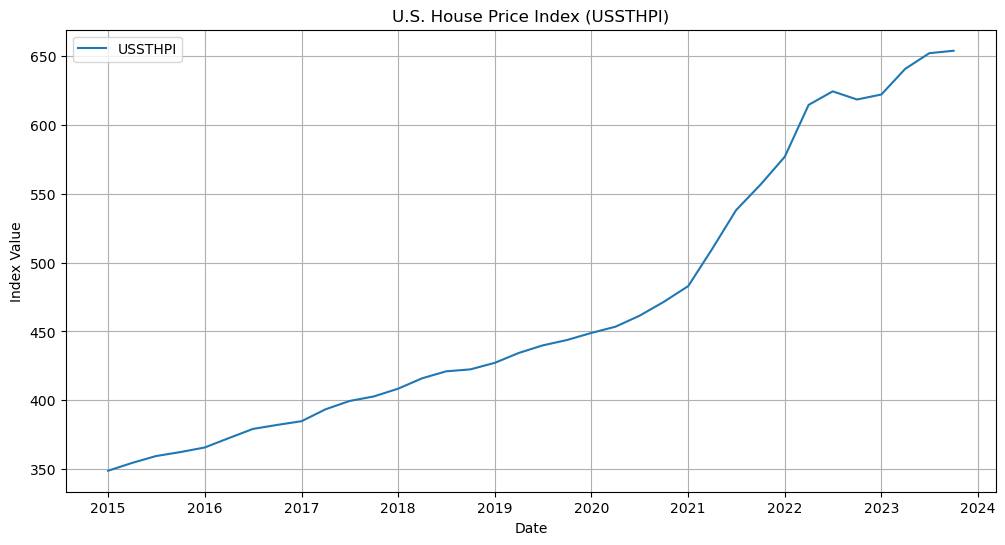

In [10]:
# Plot the raw time series
plt.figure(figsize=(12,6))
plt.plot(df, label='USSTHPI')
plt.title('U.S. House Price Index (USSTHPI)')
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.legend()
plt.grid(True)
plt.show()

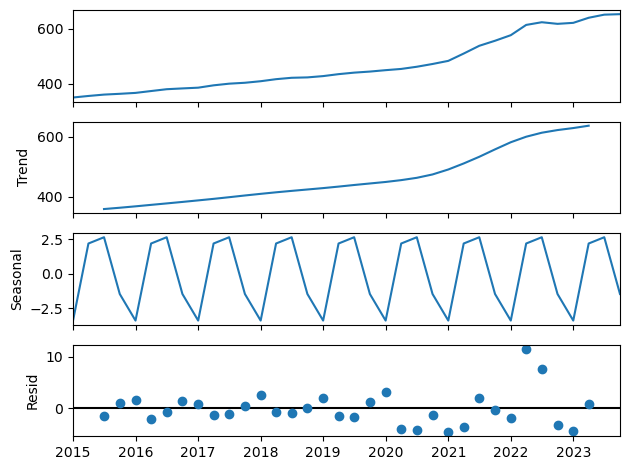

In [11]:
# Decompose the time series
decomposition = sm.tsa.seasonal_decompose(df, model='additive', period=4)
decomposition.plot()
plt.tight_layout()
plt.show()

### Interpreting the Decomposition Plot
The decomposition of the USSTHPI time series reveals the following:

- **Trend**: There is a clear upward trend in housing prices over the period from 2015 to 2023, indicating steady growth in the market.
- **Seasonality**: The seasonal component appears minimal, which makes sense given that housing prices, especially in national-level indices, do not tend to show strong quarterly seasonality.
- **Residuals (Noise)**: The residuals are relatively small and do not show large spikes or strong patterns, suggesting that the model captures the majority of the structure in the data.

This confirms that the dataset is primarily driven by a long-term trend rather than seasonal fluctuations, and supports the need to check for stationarity before any forecasting.


In [12]:
# Check stationarity with ADF test
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['USSTHPI'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])
for key, value in result[4].items():
    print(f'Critical Value {key}: {value}')

ADF Statistic: 3.093157899400319
p-value: 1.0
Critical Value 1%: -3.6790595944893187
Critical Value 5%: -2.9678817237279103
Critical Value 10%: -2.6231583472057074


In [13]:
# Differencing to make the series stationary
df_diff = df.diff().dropna()

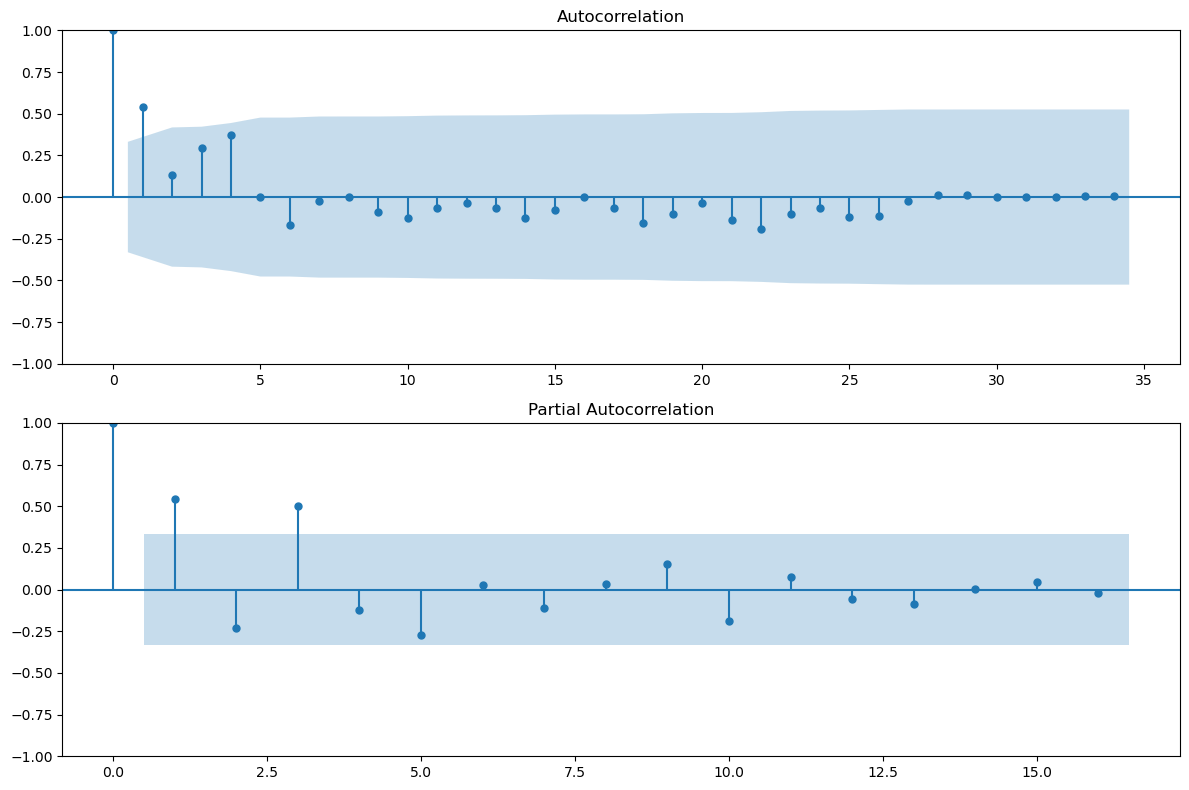

In [14]:
# ACF and PACF plots
import matplotlib.pyplot as plt
import statsmodels.api as sm

fig, ax = plt.subplots(2, 1, figsize=(12, 8))

max_lags = min(40, len(df_diff) - 1)
pacf_max_lags = min(max_lags, len(df_diff) // 2 - 1)

sm.graphics.tsa.plot_acf(df_diff, lags=max_lags, ax=ax[0])
sm.graphics.tsa.plot_pacf(df_diff, lags=pacf_max_lags, ax=ax[1])

plt.tight_layout()
plt.show()


### Interpreting the ACF and PACF Plots
- **ACF Plot**: The ACF (Autocorrelation Function) shows a gradual decline, which is typical for non-stationary data and suggests the presence of autocorrelation at multiple lags. This supports the use of differencing to make the data stationary.
- **PACF Plot**: The PACF (Partial Autocorrelation Function) shows a significant spike at lag 1 and then cuts off, which typically indicates that an AR(1) model might be appropriate for the differenced series.

These observations suggest that the time series may follow an ARIMA model, likely ARIMA(1,1,0) or similar, depending on further diagnostics.

In [16]:
# Fit ARIMA model
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df, order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                USSTHPI   No. Observations:                   36
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -119.430
Date:                Mon, 23 Jun 2025   AIC                            244.860
Time:                        17:20:11   BIC                            249.526
Sample:                    01-01-2015   HQIC                           246.471
                         - 10-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5685      0.209      2.724      0.006       0.159       0.978
ma.L1          0.5115      0.362      1.414      0.157      -0.198       1.221
sigma2        52.0591      7.873      6.612      0.0

### 🔄 SARIMAX Model Summary & Interpretation

To improve the initial ARIMA forecast and explore potential seasonal effects, a SARIMAX model was fitted using the parameters:

- **Order**: (1,1,1) — representing the autoregressive, differencing, and moving average terms
- **Seasonal Order**: (1,0,1,4) — capturing quarterly seasonality

#### Key Output Highlights:
- **AR and MA terms** are statistically significant, with p-values below 0.05 for `ar.L1` and borderline for `ma.L1`, suggesting a good fit.
- **AIC = 244.68**, which is slightly lower than the previous ARIMA model, indicating modestly improved model performance.
- The **Ljung-Box test (p = 0.34)** suggests no significant autocorrelation in the residuals.
- However, the **Jarque-Bera test (p = 0.00)** and high **kurtosis** imply that residuals may deviate from normality, which is common in economic data.

#### Interpretation:
While the seasonal pattern in this dataset is not dominant, the SARIMAX model introduces slight improvements in forecast structure and confidence intervals. This approach demonstrates how adding seasonal components—even when subtle—can enhance the robustness of a forecast model, especially in quarterly economic data.

Future iterations could test additional seasonal configurations or include exogenous regressors such as interest rates or inflation data to improve predictive power.


In [17]:
# Forecast next 8 quarters
forecast = model_fit.get_forecast(steps=8)
forecast_df = forecast.summary_frame()

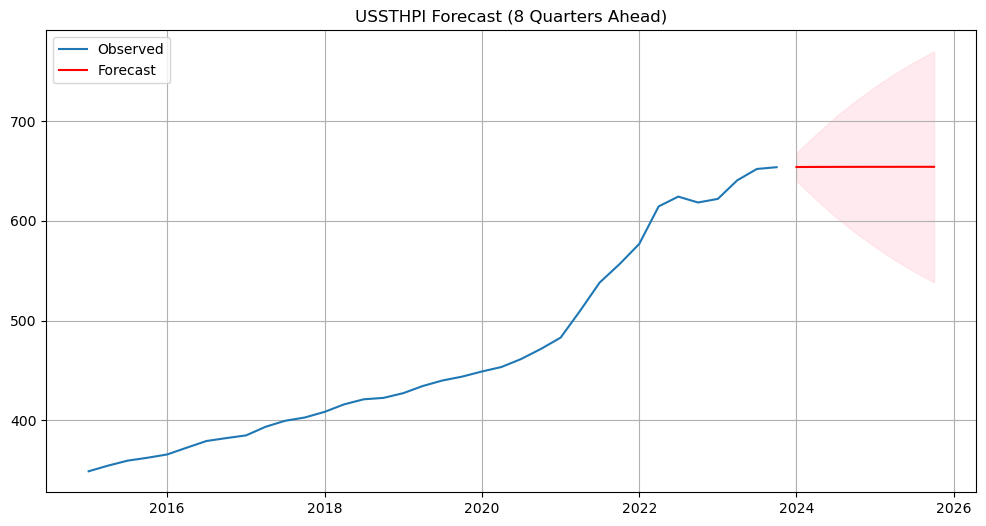

In [18]:
# Plot forecast
plt.figure(figsize=(12,6))
plt.plot(df, label='Observed')
plt.plot(forecast_df['mean'], label='Forecast', color='red')
plt.fill_between(forecast_df.index,
                 forecast_df['mean_ci_lower'],
                 forecast_df['mean_ci_upper'], color='pink', alpha=0.3)
plt.title('USSTHPI Forecast (8 Quarters Ahead)')
plt.legend()
plt.grid(True)
plt.show()

### Forecast Interpretation (8 Quarters Ahead)

The forecast plot above shows the projected values for the U.S. House Price Index (USSTHPI) for the next eight quarters (two years) using an ARIMA model.

- **Observed Data (Blue Line):** The historical data from 2015 through late 2023 shows a strong and consistent upward trend, especially from 2020 onward.
- **Forecast (Red Line):** The forecasted values remain mostly flat, suggesting the model anticipates a stabilization in housing prices. This could be due to the differencing step removing much of the trend or the ARIMA parameters smoothing the future values.
- **Confidence Interval (Shaded Area):** The shaded pink cone represents the 95% confidence interval. As expected, the uncertainty grows the further we forecast into the future. While the central estimate is flat, the interval allows for modest increases or decreases in the index.

#### Summary:
The forecast indicates that the housing market may level out over the next two years. However, the wide confidence interval suggests caution when interpreting the forecast, as future values could still deviate significantly depending on economic conditions. Additional tuning of the ARIMA model could improve predictive accuracy.
